# Structural Breaks in Time Series

Juan Guzman

Exploring how to fit a model to the weekly non-seasonally adjusted M1 data from January 6, 1975 to February 1, 2024.

M1 is a measure of money.

It consists of the most liquid forms of money, namely currency, demand deposits, and other liquid deposits.

Data Found and downloaded from the weekly non-seasonally adjusted M1 from January 6, 1975 to Feb 1, 2024 from FRED

Data found here: https://fred.stlouisfed.org/series/M1NS.

In [ ]:
%load_ext rpy2.ipython

# 1. Installing necessary packages for the analysis:

In [ ]:
%%R
install.packages("tidyverse")
install.packages("tseries")
install.packages("forecast")
install.packages("zoo")
install.packages("lmtest")
install.packages("strucchange")
install.packages("CPAT")

In [ ]:
%%R
library(readxl)
library(lubridate)
library(tseries)
library(forecast)
library(zoo)
library(tidyverse)
library(lmtest)

library(CPAT)

In [ ]:
%%R
library(strucchange)

# 2. Plotting the time series.

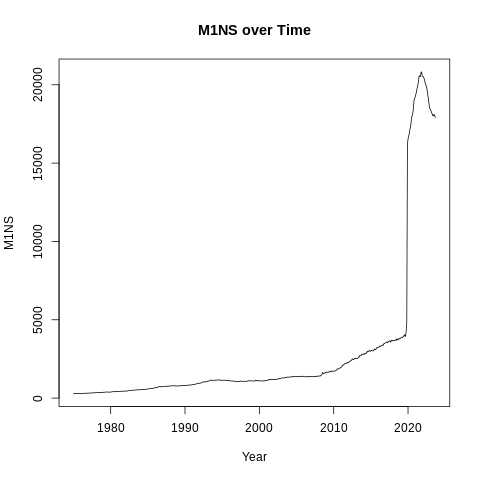

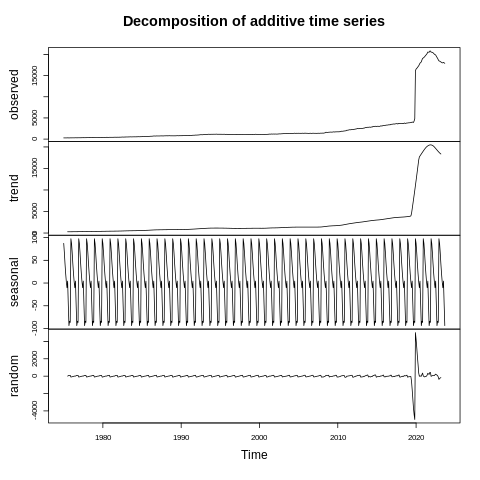

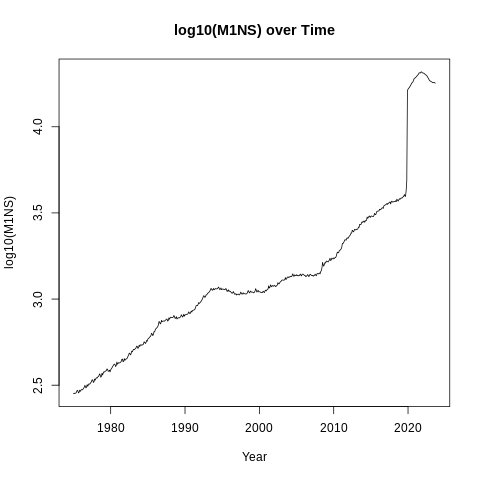

In [ ]:
%%R

stlouis_data <- read.csv("/content/drive/MyDrive/STAT619 - Time series analysis /M1NS.csv", col.name = c('DATE', 'M1NS'), skip =5, )

stlouis_data$DATE <- as.Date(stlouis_data$DATE, origin = "1975-01-01")

# Create a time series object
stlouis_ts <- ts(stlouis_data$M1NS, start = c(year(min(stlouis_data$DATE))), frequency = 12)

# Plot the time series
plot(stlouis_ts, main = "M1NS over Time", xlab = "Year", ylab = "M1NS")

# Decompose the time series
stlouis_components <- decompose(stlouis_ts)
plot(stlouis_components)

stlouis_data$M1NS <- log10(stlouis_data$M1NS)

# Create a log time series object
stlouis_log_ts <- ts(stlouis_data$M1NS, start = c(year(min(stlouis_data$DATE))), frequency = 12)

# Plot the log time series
plot(stlouis_log_ts, main = "log10(M1NS) over Time", xlab = "Year", ylab = "log10(M1NS)")

The time series, clearly a severe structural break around 2020. We may also need to do a log transformation of the data.

The original time series looks flat until 2020 when the M1NS jumps significantly

This could indicate that the data needs a log transformation to better visualize the data the decomposition of the time series shows the a severe structural break at 2020.

The time series also shows seasonality and randomeness.

# 2. Plotting ACF and PACF for M1.

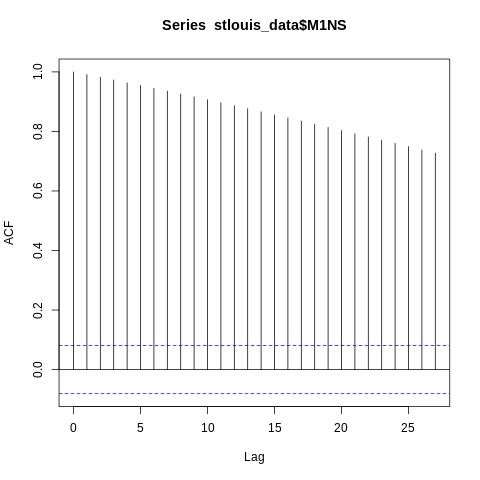

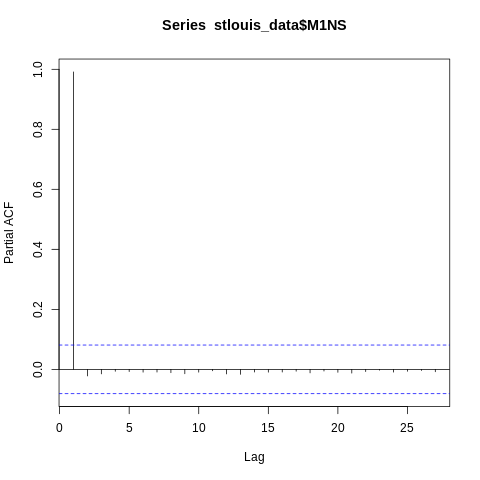

In [ ]:
%%R

acf(stlouis_data$M1NS)
pacf(stlouis_data$M1NS)


The acf has no break and keeps decreasing not going to zero even at 20 lags, the pacf drops off immediately to zero after the first lag

# 3. Addressing structural breaks.

Using appropriate models to fit the data and check for residuals.

Using transformations and/or structural break if necessary.


NULL


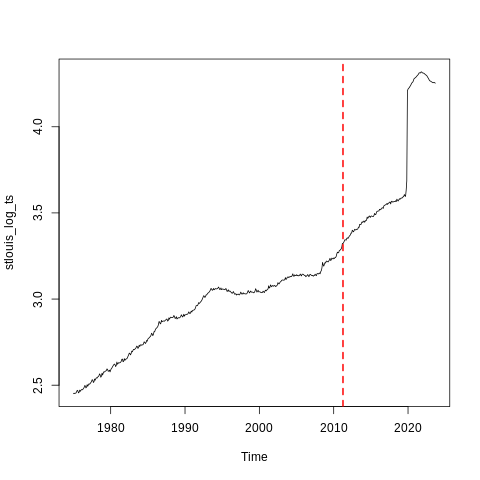

In [ ]:
%%R

stlouis_breaks <- Fstats(stlouis_log_ts ~ 1)

plot(stlouis_log_ts)
lines(breakpoints(stlouis_breaks), col='red', lwd = 2, lty = 2)

stlouis_breaks$breakpoints

# Structural breaks correspond to resessions as indicated in the website

# There is also a severe structural break during 2020
# Which is not identified by the code.

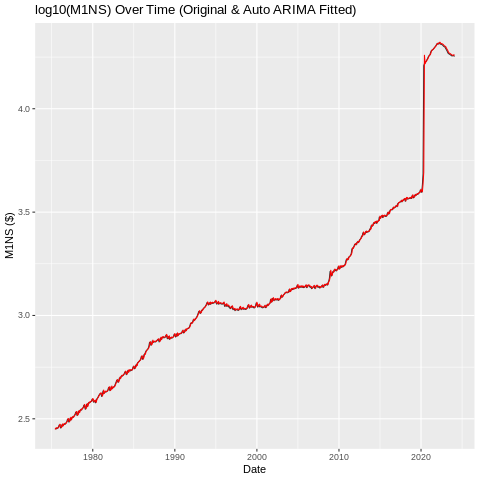

In [ ]:
%%R
### Let's check fit auto ARIMA, and SARIMA models ###
######### Using auto.ARIMA to fit the ARIMA model ###############
ARIMA_model_auto <- auto.arima(stlouis_log_ts, seasonal = FALSE)

# Plot the M1NS time series along with fitted values for the MA model
ggplot(data = stlouis_data, aes(x = DATE, y = M1NS)) +
  geom_line(color = 'black', alpha = 0.8) +
  geom_line(aes(y = fitted(ARIMA_model_auto)), color = 'red') +
  labs(title = "log10(M1NS) Over Time (Original & Auto ARIMA Fitted)", x = "Date", y = "M1NS ($)")

In [ ]:
%%R
summary(ARIMA_model_auto)

# Series: stlouis_log_ts
# ARIMA(0,1,1) with drift

# Coefficients:
#          ma1   drift
#       0.0913  0.0031
# s.e.  0.0398  0.0010

# sigma^2 = 0.0005117:  log likelihood = 1385.07
# AIC = -2764.15   AICc = -2764.1   BIC = -2751.04

# Training set error measures:
#                        ME       RMSE         MAE          MPE      MAPE
# Training set 3.690444e-06 0.02256193 0.006394518 -0.006975599 0.2010722
#                   MASE        ACF1
# Training set 0.1544353 0.003556546

Series: stlouis_log_ts 
ARIMA(0,1,1) with drift 

Coefficients:
         ma1   drift
      0.0913  0.0031
s.e.  0.0398  0.0010

sigma^2 = 0.0005117:  log likelihood = 1385.07
AIC=-2764.15   AICc=-2764.1   BIC=-2751.04

Training set error measures:
                       ME       RMSE         MAE          MPE      MAPE
Training set 3.690444e-06 0.02256193 0.006394518 -0.006975599 0.2010722
                  MASE        ACF1
Training set 0.1544353 0.003556546


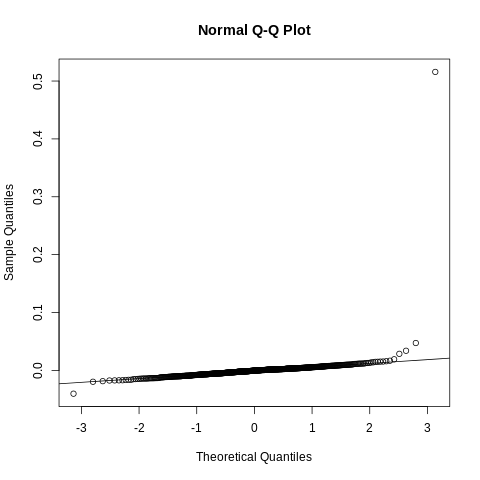

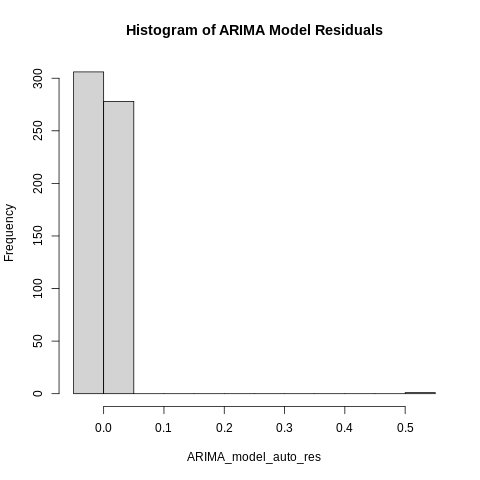

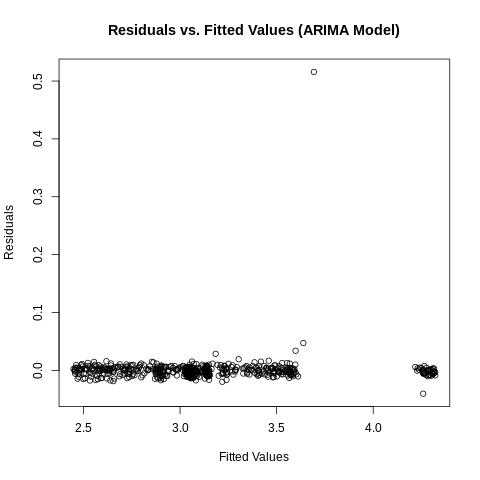

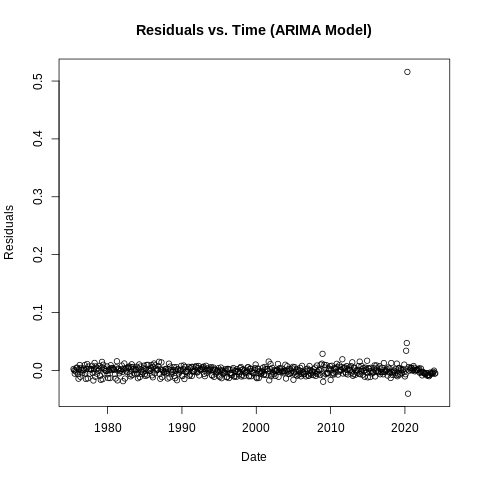

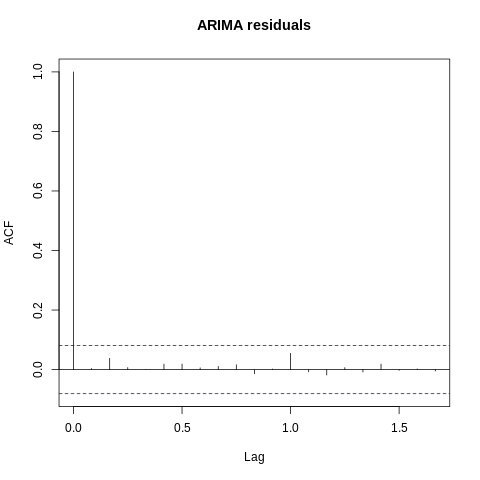

In [ ]:
%%R
# Residual analysis for AR model
ARIMA_model_auto_res <- residuals(ARIMA_model_auto)

# Normality probability plot
qqnorm(ARIMA_model_auto_res)
qqline(ARIMA_model_auto_res)

# Histogram
hist(ARIMA_model_auto_res, main = "Histogram of ARIMA Model Residuals")

# Residuals vs. Fitted Values
plot(fitted(ARIMA_model_auto), ARIMA_model_auto_res, main = "Residuals vs. Fitted Values (ARIMA Model)", xlab = "Fitted Values", ylab = "Residuals")

# Residuals vs. Time
plot(stlouis_data$DATE, ARIMA_model_auto_res, main = "Residuals vs. Time (ARIMA Model)", xlab = "Date", ylab = "Residuals")

acf(ARIMA_model_auto_res, lag.max=20, main = 'ARIMA residuals')

In [ ]:
# There is only one value that is very odd, and is a significant outlier

In [ ]:
%%R
Box.test(ARIMA_model_auto_res, lag=20, type="Ljung-Box")


	Box-Ljung test

data:  ARIMA_model_auto_res
X-squared = 3.9488, df = 20, p-value = 1



In [ ]:
#The p value is higher than 0.05, which means that the residuals are not
# Autocorrelated, so the model is good

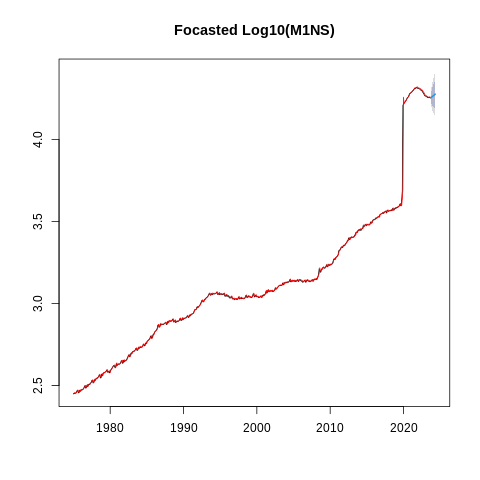

In [ ]:
%%R
ARIMA_forecast <- forecast(ARIMA_model_auto, h = 8)
ARIMA_forecast

# Plot the forecasted values along with the historical data
plot(ARIMA_forecast, main = 'Focasted Log10(M1NS)')
lines(ARIMA_forecast$fitted, col='red')

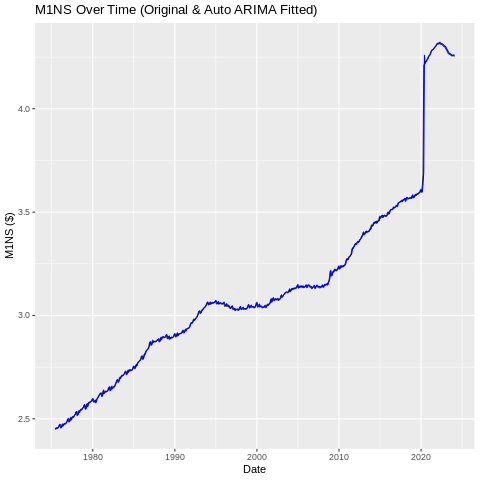

In [ ]:
%%R
####### Using seasonal auto.ARIMA to fit the ARIMA model ##########
SARIMA_model <- auto.arima(stlouis_log_ts, seasonal = TRUE)

# Plot the M1NS time series along with fitted values for the MA model
ggplot(data = stlouis_data, aes(x = DATE, y = M1NS)) +
  geom_line(color = 'black', alpha = 0.8) +
  geom_line(aes(y = fitted(SARIMA_model)), color = 'blue') +
  labs(title = "M1NS Over Time (Original & Auto ARIMA Fitted)", x = "Date", y = "M1NS ($)")

In [ ]:
%%R
summary(SARIMA_model)

# Series: stlouis_log_ts
# ARIMA(0,1,1) with drift

# Coefficients:
#          ma1   drift
#       0.0913  0.0031
# s.e.  0.0398  0.0010

# sigma^2 = 0.0005117:  log likelihood = 1385.07
# AIC=-2764.15   AICc=-2764.1   BIC=-2751.04


# Training set error measures:
#                        ME       RMSE         MAE          MPE      MAPE
# Training set 3.690444e-06 0.02256193 0.006394518 -0.006975599 0.2010722
#                   MASE        ACF1
# Training set 0.1544353 0.003556546

Series: stlouis_log_ts 
ARIMA(0,1,1) with drift 

Coefficients:
         ma1   drift
      0.0913  0.0031
s.e.  0.0398  0.0010

sigma^2 = 0.0005117:  log likelihood = 1385.07
AIC=-2764.15   AICc=-2764.1   BIC=-2751.04

Training set error measures:
                       ME       RMSE         MAE          MPE      MAPE
Training set 3.690444e-06 0.02256193 0.006394518 -0.006975599 0.2010722
                  MASE        ACF1
Training set 0.1544353 0.003556546


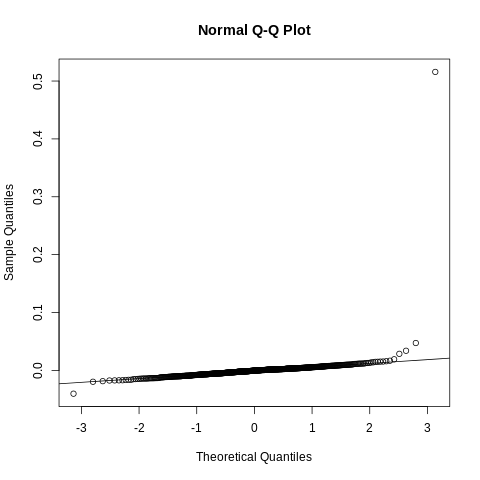

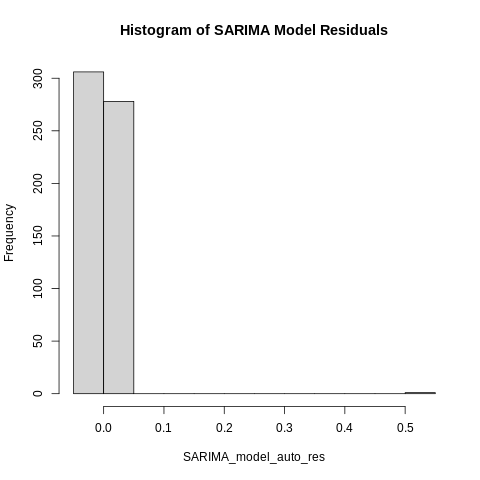

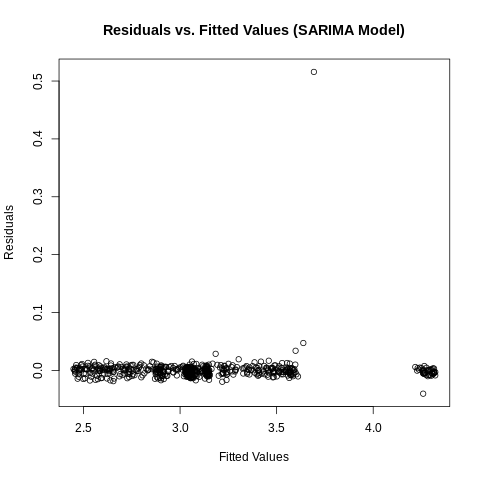

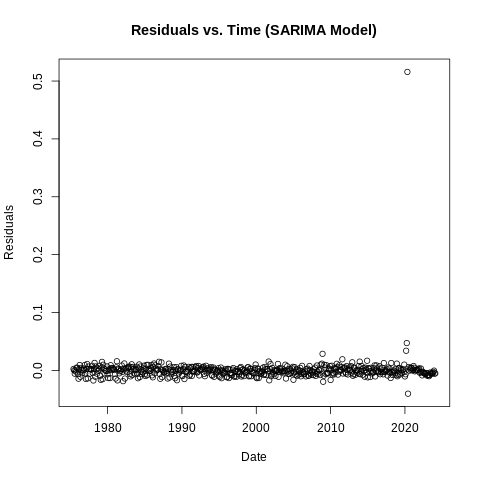

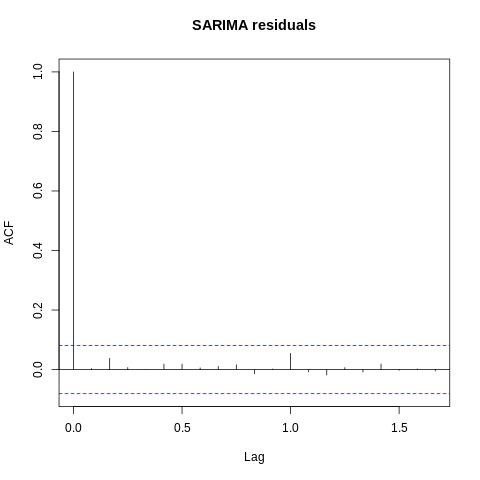

In [ ]:
%%R
################### Residual analysis for SARIMA model #########################
SARIMA_model_auto_res <- residuals(SARIMA_model)

# Normality probability plot
qqnorm(SARIMA_model_auto_res)
qqline(SARIMA_model_auto_res)

# Histogram
hist(SARIMA_model_auto_res, main = "Histogram of SARIMA Model Residuals")

# Residuals vs. Fitted Values
plot(fitted(SARIMA_model), SARIMA_model_auto_res, main = "Residuals vs. Fitted Values (SARIMA Model)", xlab = "Fitted Values", ylab = "Residuals")

# Residuals vs. Time
plot(stlouis_data$DATE, SARIMA_model_auto_res, main = "Residuals vs. Time (SARIMA Model)", xlab = "Date", ylab = "Residuals")

acf(SARIMA_model_auto_res, lag.max=20, main = 'SARIMA residuals')

In [ ]:
%%R
Box.test(SARIMA_model_auto_res, lag=20, type="Ljung-Box")


	Box-Ljung test

data:  SARIMA_model_auto_res
X-squared = 3.9488, df = 20, p-value = 1



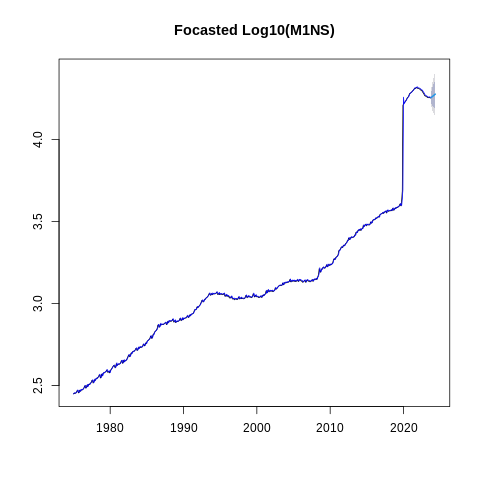

In [ ]:
%%R
SARIMA_forecast <- forecast(SARIMA_model, h = 8)
SARIMA_forecast

# Plot the forecasted values along with the historical data
plot(SARIMA_forecast, main = 'Focasted Log10(M1NS)')
lines(SARIMA_forecast$fitted, col='blue')

In [ ]:
# The auto ARIMA and auto seasonal ARIMA give the same results.
# That could mean that auto ARIMA picks up the trending of the time series.

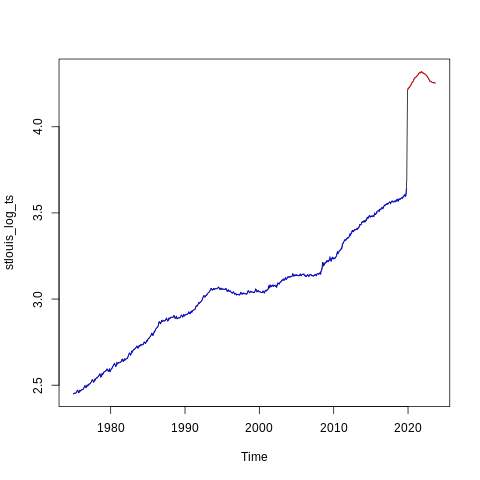

In [ ]:
%%R
# The time series still has a severe breakdown at 2020
# I'll split the time series and explore how both behave

# The break is identified at around 2020
# Split the data
data_pre_break <- window(stlouis_log_ts, end = c(2019,11))
data_post_break <- window(stlouis_log_ts, start = c(2019,12))

# Fit models separately
model_pre <- auto.arima(data_pre_break)
model_post <- auto.arima(data_post_break)

# Plot with both models
plot(stlouis_log_ts)
lines(fitted(model_pre), col='blue')
lines(fitted(model_post), col='red')

In [ ]:
%%R
summary(model_pre)

# Series: data_pre_break
# ARIMA(1,1,1)(2,0,0)[12] with drift

# Coefficients:
#          ar1      ma1    sar1    sar2   drift
#       0.8490  -0.7395  0.5976  0.2436  0.0032
# s.e.  0.0735   0.0882  0.0473  0.0480  0.0020

# sigma^2 = 2.328e-05:  log likelihood = 2102.15
# AIC=-4192.3   AICc=-4192.14   BIC=-4166.57

# Training set error measures:
#                        ME        RMSE         MAE          MPE      MAPE
# Training set 3.922284e-05 0.004798417 0.003247706 0.0006337651 0.1057438
#                   MASE        ACF1
# Training set 0.1169783 0.002051006

Series: data_pre_break 
ARIMA(1,1,1)(2,0,0)[12] with drift 

Coefficients:
         ar1      ma1    sar1    sar2   drift
      0.8490  -0.7395  0.5976  0.2436  0.0032
s.e.  0.0735   0.0882  0.0473  0.0480  0.0020

sigma^2 = 2.328e-05:  log likelihood = 2102.15
AIC=-4192.3   AICc=-4192.14   BIC=-4166.57

Training set error measures:
                       ME        RMSE         MAE          MPE      MAPE
Training set 3.922284e-05 0.004798417 0.003247706 0.0006337651 0.1057438
                  MASE        ACF1
Training set 0.1169783 0.002051006


In [ ]:
%%R
summary(model_post)

# Series: data_post_break
# ARIMA(2,2,0)(1,0,0)[12]

# Coefficients:
#           ar1      ar2    sar1
#       -0.2525  -0.5388  0.4876
# s.e.   0.1365   0.1414  0.1536

# sigma^2 = 6.06e-06:  log likelihood = 204.81
# AIC=-401.61   AICc=-400.59   BIC=-394.48

# Training set error measures:
#                         ME        RMSE         MAE          MPE       MAPE
# Training set -0.0002110791 0.002324161 0.001869045 -0.004913614 0.04374081
#                    MASE       ACF1
# Training set 0.04528033 0.07151036`

Series: data_post_break 
ARIMA(2,2,0)(1,0,0)[12] 

Coefficients:
          ar1      ar2    sar1
      -0.2525  -0.5388  0.4876
s.e.   0.1365   0.1414  0.1536

sigma^2 = 6.06e-06:  log likelihood = 204.81
AIC=-401.61   AICc=-400.59   BIC=-394.48

Training set error measures:
                        ME        RMSE         MAE          MPE       MAPE
Training set -0.0002110791 0.002324161 0.001869045 -0.004913614 0.04374081
                   MASE       ACF1
Training set 0.04528033 0.07151036


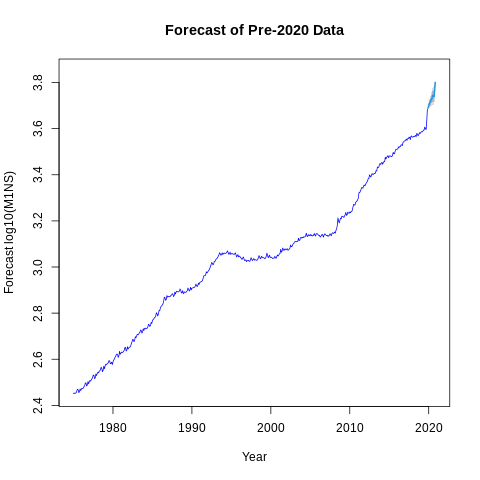

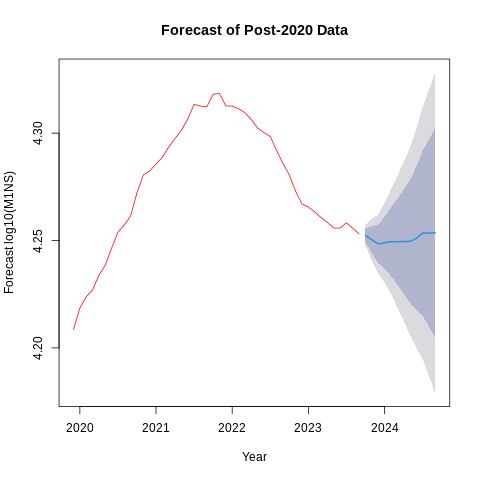

In [ ]:
%%R
# Forecast each model
forecast_pre <- forecast(model_pre, h = 12)  # Forecast for the next year
forecast_post <- forecast(model_post, h = 12)  # Forecast for the next year


plot(forecast_pre, main = "Forecast of Pre-2020 Data", xlab = "Year", ylab = "Forecast log10(M1NS)", col = 'blue')
plot(forecast_post, main = "Forecast of Post-2020 Data", xlab = "Year", ylab = "Forecast log10(M1NS)", col = 'red')

Clearly the structural break at 2020 is so significant that a forecast is unable to predict the increase.

Maybe a significant global event could have caused the structural break in the time series?